In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
plt.style.use('jpg.mplstyle')

In [3]:
path = '/tigress/jgreco/hsc-s18a/synths/imfit-hugs-cats/imfit-runs/run-1/'
imfit_cat = pd.read_csv(path + 'gmod-s18a-synths-imfit-cat.csv')
hugs_cat = pd.read_csv(path + 'hugs-imfit.csv')
synth_cat = Table.read(path + 'global-synth-cat.fits').to_pandas()

In [4]:
imfit_cat.set_index('id', inplace=True)
hugs_cat.set_index('id', inplace=True)
meas = imfit_cat.join(hugs_cat, rsuffix='_hugs')

In [5]:
ra_nan, dec_nan, flags = meas.loc[meas.ra.isnull().values, ['ra_hugs', 'dec_hugs', 'flag']].values.T

## Flags

- 1: cutout fail
- 2: no PSF
- 3: crazy error on size
- 4: imfit error (i.e., imfit actually failed)
- 5: ell or PA measurment error (probably nan)

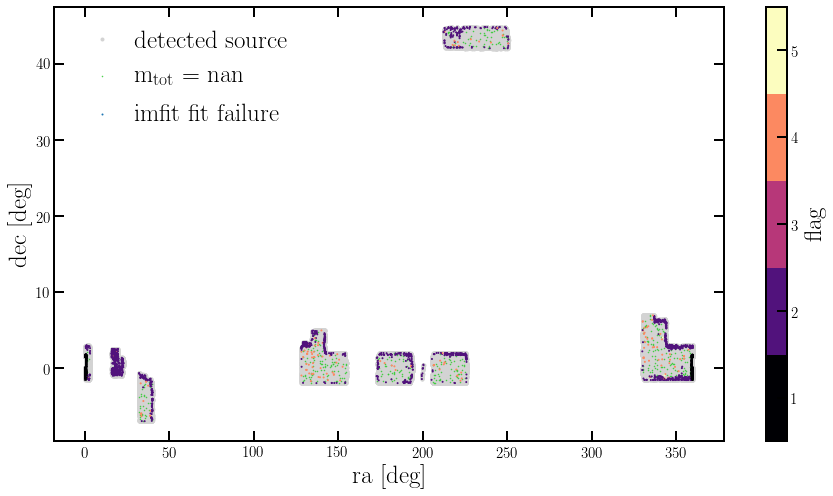

In [6]:
plt.figure(figsize=(15, 8))

cmap = plt.cm.get_cmap('magma', 5)    

plt.plot(meas['ra_hugs'], meas['dec_hugs'], '.', c='lightgray', zorder=-10, label='detected source')

plt.plot(meas.loc[meas['m_tot_forced_r'].isna(),['ra']], 
         meas.loc[meas['m_tot_forced_r'].isna(),['dec']], 
         '.', c='limegreen', ms=1, label=r'm$_\mathrm{tot}$ = nan')

plt.scatter(ra_nan, dec_nan, marker='.', zorder=10, c=flags, s=4,
            label='imfit fit failure', cmap=cmap, vmin=1 - 0.5, vmax=5 + 0.5)
cax = plt.colorbar()
cax.set_label('flag', fontsize=25)

plt.xlabel('ra [deg]', fontsize=25)
plt.ylabel('dec [deg]', fontsize=25)

plt.legend(loc='upper left', fontsize=25);

In [7]:
meas = meas.loc[~meas.ra.isnull().values]
meas = meas.loc[~meas['m_tot'].isna()]
meas.isna().any().sum()

0

In [8]:
len(meas), len(synth_cat), len(meas) / len(synth_cat)

(122620, 322361, 0.3803810014238695)

In [9]:
def _clip_outlier_mask(cat, param_name=None, percentiles=[0.001, 99.999]):
    if param_name is not None:
        pmin, pmax = np.percentile(cat[param_name], percentiles)
        mask = (cat[param_name] > pmin) & (cat[param_name] < pmax)
    else:
        pmin, pmax = np.percentile(cat, percentiles)
        mask = (cat > pmin) & (cat < pmax)
    return mask

def _get_clipped_param(hugs_cat, hugs_param_name, synth_cat, synth_param_name,
                       **kwargs):
    mask = _clip_outlier_mask(hugs_cat, hugs_param_name, **kwargs)
    hugs_param = hugs_cat.loc[mask, hugs_param_name]
    synth_param = synth_cat.loc[mask, synth_param_name]
    return hugs_param, synth_param

def _get_16_50_84(param):
    lo, med, hi = np.percentile(param, [16, 50, 84])
    return lo, med, hi

In [10]:
synth_meas = synth_cat.merge(meas, on='synth_id', suffixes=['_input', ''], how='right')

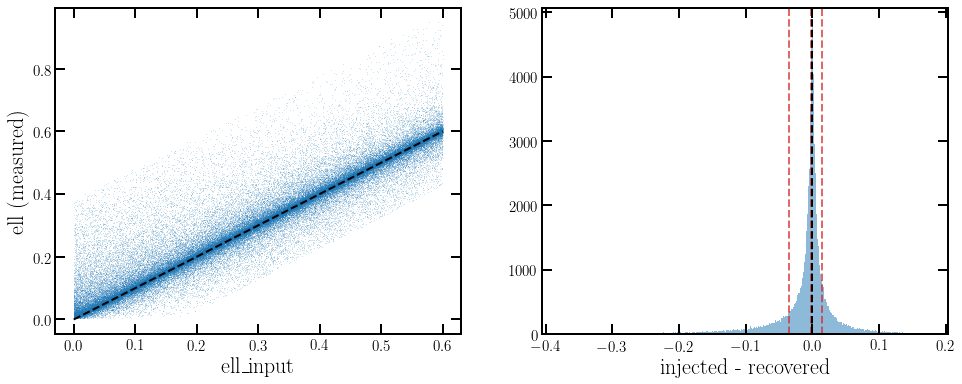

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

params = ['ell_input', 'ell']
clip_per = 1

fs = 22
log=False

par_in = synth_meas[params[0]].copy()
par_out = synth_meas[params[1]].copy()

diff = par_in  - par_out

if clip_per > 0:
    vmin, vmax = np.percentile(diff, [clip_per, 100-clip_per])
    mask = (diff > vmin) & (diff < vmax)

    diff = diff[mask]
    par_in = par_in[mask]
    par_out = par_out[mask]

ax[0].plot(par_in, par_out, ',', alpha=0.2)
ax[0].plot([par_in.min(), par_in.max()],
           [par_in.min(), par_in.max()],
            'k--', lw=2, zorder=10)
ax[0].set_xlabel(params[0].replace('_', '\_'), fontsize=fs)
ax[0].set_ylabel(params[1].replace('_', '\_') + ' (measured)', fontsize=fs)


stat_lines = _get_16_50_84(diff)
for stat in stat_lines:
    ax[1].axvline(x=stat, ls='--', lw=2, c='tab:red', alpha=0.7)

ax[1].hist(diff , bins='auto', log=log, alpha=0.5)
ax[1].axvline(x=0, ls='--', lw=2, color='k')

ax[1].set_xlabel('injected - recovered', fontsize=fs);

## Check impact of SE cut 

In [18]:
from scipy.special import gamma, gammaincinv

In [19]:
def mu_e_ave(mu_0, n):
    b_n = gammaincinv(2.*n, 0.5)
    f_n = gamma(2*n)*n*np.exp(b_n)/b_n**(2*n)
    mu_e = mu_0 + 2.5*b_n/np.log(10)
    mu_e_ave = mu_e - 2.5*np.log10(f_n)
    return mu_e_ave

In [20]:
max_size_diff = 10.0
max_mag_diff = 1.0
max_cen_diff = 4.0

max_ell = 0.7
max_mu0 = 29.0
min_mu0 = 22.5

In [21]:
# centroid cut
dR0 = np.sqrt(synth_meas.dX0**2 + synth_meas.dY0**2)*0.168
dR0_cut = dR0 < max_cen_diff

# magnitude and size cuts
dmag_i = synth_meas.m_tot - synth_meas.mag_auto_i
dmag_g = synth_meas.m_tot_forced_g - synth_meas.mag_auto_g
dmag_r = synth_meas.m_tot_forced_r - synth_meas.mag_auto_r
dmag_i_cut = np.abs(dmag_i) < max_mag_diff
dmag_g_cut = np.abs(dmag_g) < max_mag_diff
dmag_r_cut = np.abs(dmag_r) < max_mag_diff
dmag_cut = dmag_i_cut & dmag_g_cut & dmag_r_cut

# size cut
dre = synth_meas.r_e - synth_meas.flux_radius_ave_i
dre_cut = np.abs(dre) < max_size_diff

# SB cut
low = min_mu0
high = max_mu0
A_g = 0.0 

mu_0_cut = (synth_meas.mu_0_forced_g - A_g > low) &\
           (synth_meas.mu_0_forced_g - A_g < high)
mu_e_cut = (synth_meas.mu_e_ave_forced_g - A_g >  mu_e_ave(low, 0.8)) &\
           (synth_meas.mu_e_ave_forced_g - A_g <  mu_e_ave(high, 0.8))

# ellipticity cut
ell_cut = synth_meas.ell < max_ell

# final cut
sample_cut = mu_e_cut & dR0_cut & dmag_cut & dre_cut & ell_cut

print('number sources cut')
print('------------------')
print('mu_e cut:', (~mu_e_cut).sum())
print('dR0 cut:', (~dR0_cut).sum())
print('dmag cut:', (~dmag_cut).sum())
print('dr_e cut:', (~dre_cut).sum())
print('dell cut:', (~ell_cut).sum())
print('------------------\n')
print('sample size after cuts: ', sample_cut.sum())

number sources cut
------------------
mu_e cut: 9622
dR0 cut: 1851
dmag cut: 15868
dr_e cut: 9816
dell cut: 1086
------------------

sample size after cuts:  101654


## What are we cutting? 

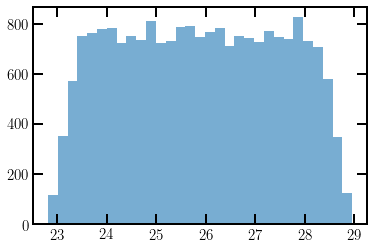

In [22]:
plt.hist(synth_cat.loc[~sample_cut.values, 'mu_e_ave_g'], bins='auto', alpha=0.6);

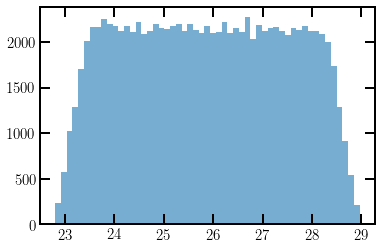

In [23]:
plt.hist(synth_cat.loc[sample_cut.values, 'mu_e_ave_g'], bins='auto', alpha=0.6);

# Shit it is not good...

Looks like we are cutting mocks of all surface brightnesses from the imfit vs SE parameter cuts!

In [24]:
print('{:.2f}% of sources cut'.format((1 - sample_cut.sum() / len(synth_meas))*100))

17.10% of sources cut
